In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from tensorflow.keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers
%matplotlib inline

In [2]:
filepath = 'C:/Users/rehan/mitbih_database/'
classnames = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classnames)
count_classes = [0]*n_classes

X = list()
y = list()


In [3]:

filenames = next(os.walk(filepath))[2]


signaldata = list()
annotations = list()
filenames.sort()
print((filenames))


['100.csv', '100annotations.txt', '101.csv', '101annotations.txt', '102.csv', '102annotations.txt', '103.csv', '103annotations.txt', '104.csv', '104annotations.txt', '105.csv', '105annotations.txt', '106.csv', '106annotations.txt', '107.csv', '107annotations.txt', '108.csv', '108annotations.txt', '109.csv', '109annotations.txt', '111.csv', '111annotations.txt', '112.csv', '112annotations.txt', '113.csv', '113annotations.txt', '114.csv', '114annotations.txt', '115.csv', '115annotations.txt', '116.csv', '116annotations.txt', '117.csv', '117annotations.txt', '118.csv', '118annotations.txt', '119.csv', '119annotations.txt', '121.csv', '121annotations.txt', '122.csv', '122annotations.txt', '123.csv', '123annotations.txt', '124.csv', '124annotations.txt', '200.csv', '200annotations.txt', '201.csv', '201annotations.txt', '202.csv', '202annotations.txt', '203.csv', '203annotations.txt', '205.csv', '205annotations.txt', '207.csv', '207annotations.txt', '208.csv', '208annotations.txt', '209.csv'

In [4]:
for f in filenames:
    filename, file_ext = os.path.splitext(f)

    if(file_ext == '.csv'):
        signaldata.append(filepath + filename + file_ext)

    elif(file_ext == '.txt'):
        annotations.append(filepath + filename + file_ext)


In [5]:
len(signaldata)

48

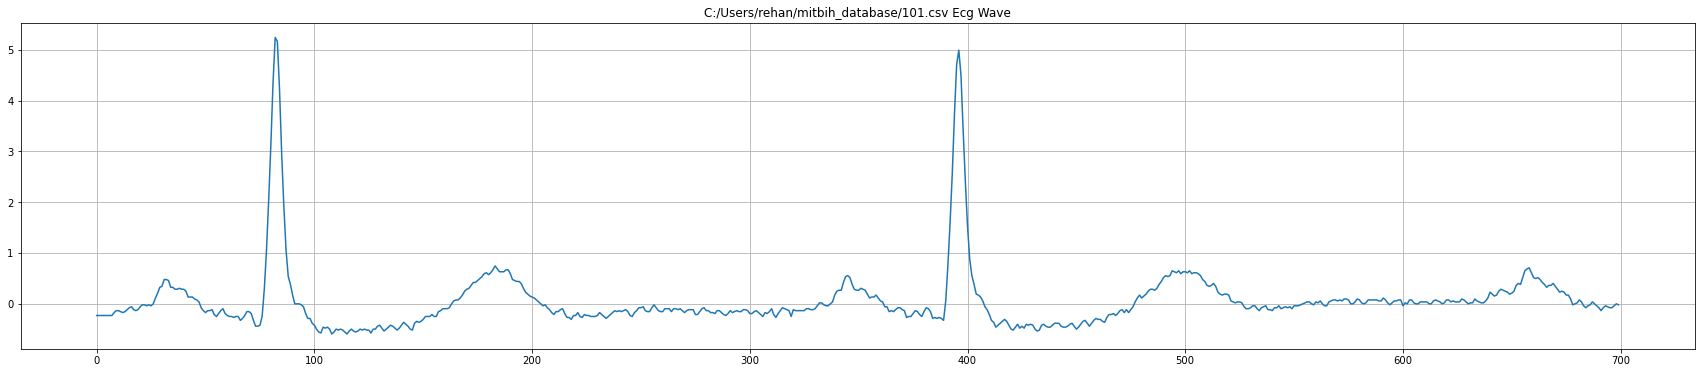

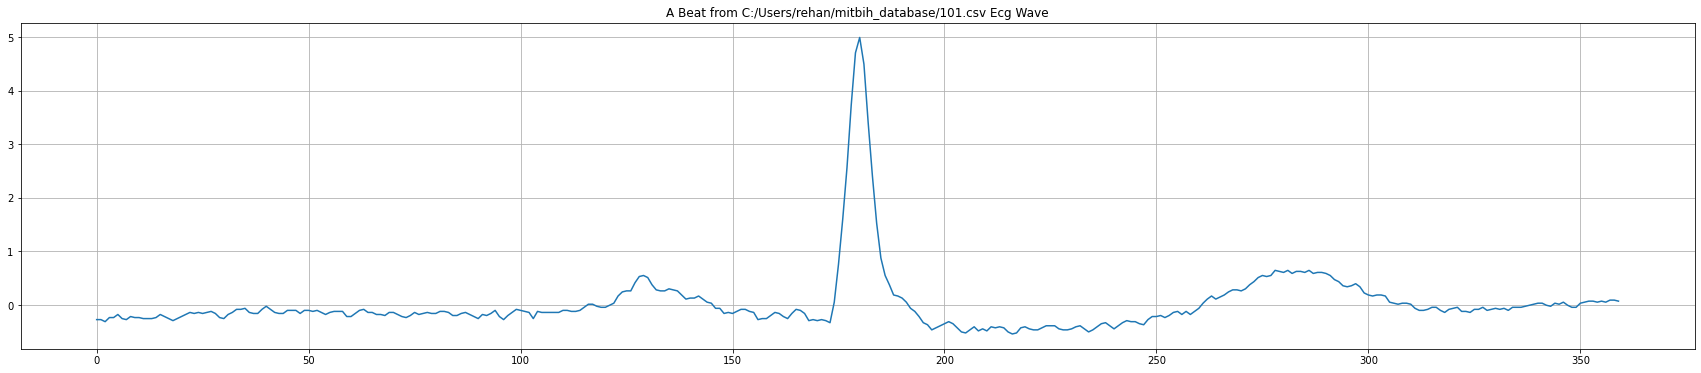

In [6]:
window_size = 180
for r in range(0, len(signaldata)):
    signals = []

    with open(signaldata[r], 'rt',) as csvfile:
        tempstorage = csv.reader(csvfile, delimiter=',',
                                 quotechar='|')
        insrtindx = -1
        for row in tempstorage:
            if(insrtindx >= 0):
                signals.insert(insrtindx, int(row[1]))
            insrtindx = insrtindx+1

    signals = stats.zscore(signals)

    if r == 1:
        plt_1 = plt.figure(figsize=(30, 6))
        plt.grid()

        plt.title(signaldata[1] + " Ecg Wave")

        plt.plot(signals[0:700])
        plt.show()
        sc=signals

    boolvar = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)):
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted)
            pos = int(next(splitted))
            class_type = next(splitted)
            if(class_type in classnames):
                c_ind = classnames.index(class_type)

                count_classes[c_ind] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]
                    if r == 1 and not boolvar:
                        plt_1 = plt.figure(figsize=(30, 6))
                        plt.grid()
                        plt.title("A Beat from " + signaldata[1] + " Ecg Wave")
                        plt.plot(beat)
                        plt.show()
                        boolvar = True

                    X.append(beat)
                    y.append(c_ind)


In [7]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])

print(np.shape(X))


(100012, 361)


0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


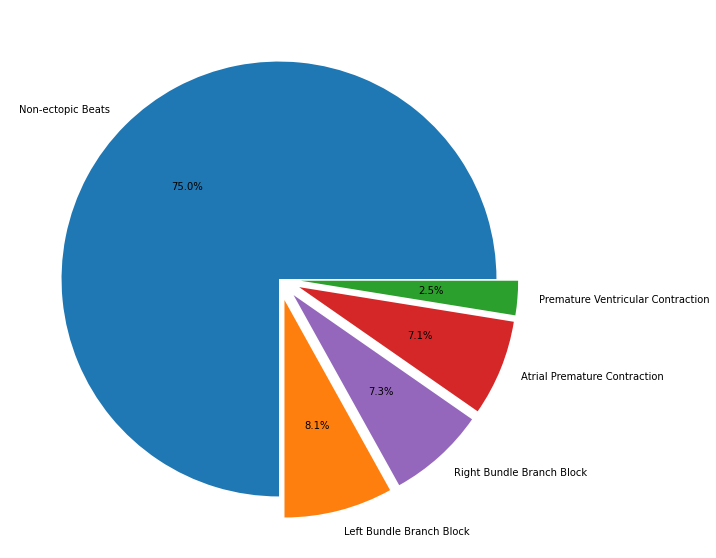

In [8]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
explode=(0,0.1,0.1,0.1,0.1)
plt.pie(per_class, labels=['Non-ectopic Beats', 'Left Bundle Branch Block', 'Right Bundle Branch Block', 'Atrial Premature Contraction', 'Premature Ventricular Contraction'],explode=explode, colors=['tab:blue','tab:orange','tab:purple','tab:red','tab:green'],autopct='%1.1f%%')
plt.show()

In [9]:
target=X_train_df.shape[1]-1
df_0=X_train_df[X_train_df[target]==0]
df_1=X_train_df[X_train_df[target]==1]
df_2=X_train_df[X_train_df[target]==2]
df_3=X_train_df[X_train_df[target]==3]
df_4=X_train_df[X_train_df[target]==4]

In [10]:
countclassno=2500



df_0_undersample=df_0.sample(countclassno,replace=True)

df_1_undersample=df_1.sample(countclassno,replace=True)
df_2_undersample=df_2.sample(countclassno,replace=True)
df_3_undersample=df_3.sample(countclassno,replace=True)
df_4_undersample=df_4.sample(countclassno,replace=True)

X_train_df=pd.concat([df_0_undersample,df_1_undersample,df_2_undersample,df_3_undersample,df_4_undersample])

0.0    2500
1.0    2500
2.0    2500
3.0    2500
4.0    2500
Name: 360, dtype: int64


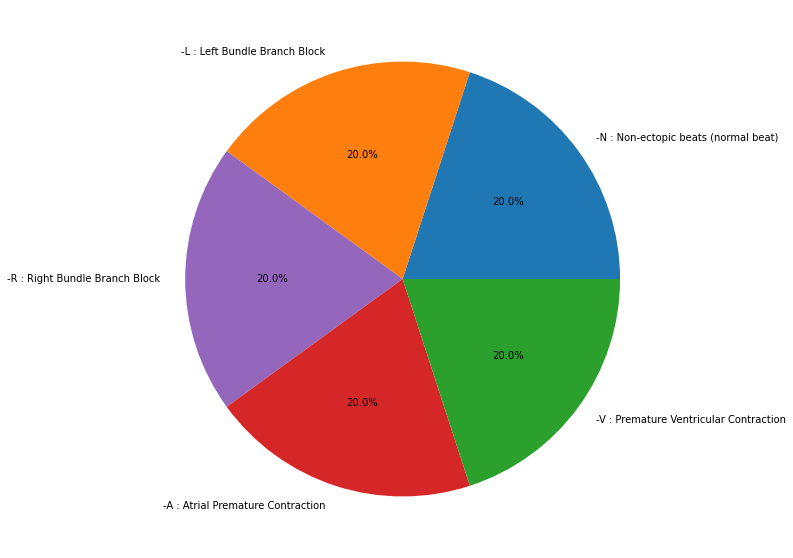

In [11]:
class_dist = X_train_df[X_train_df.shape[1]-1].value_counts()
print(class_dist)
plt.figure(figsize=(20,10))

plt.pie(class_dist, labels=['-N : Non-ectopic beats (normal beat) ', '-L : Left Bundle Branch Block ', '-R : Right Bundle Branch Block ', '-A : Atrial Premature Contraction ', '-V : Premature Ventricular Contraction'], colors=['tab:blue','tab:orange','tab:purple','tab:red','tab:green'],autopct='%1.1f%%')

plt.show()

In [12]:
train, test = train_test_split(X_train_df, test_size=0.20,random_state=45637)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (10000, 361)
X_test  :  (2500, 361)


In [13]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(10000, 5) (2500, 5)


In [14]:
train_y

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [15]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(10000, 360, 1) (2500, 360, 1)


In [16]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Softmax())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 360, 16)           224       
                                                                 
 average_pooling1d (AverageP  (None, 179, 16)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 179, 64)           17472     
                                                                 
 average_pooling1d_1 (Averag  (None, 89, 64)           0         
 ePooling1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 89, 128)           155776    
                                                                 
 average_pooling1d_2 (Averag  (None, 44, 128)          0

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [18]:
modelbase = model.fit(train_x, train_y, batch_size=36, epochs=10, verbose=1, validation_data=(test_x, test_y))

Epoch 1/10
278/278 [==============================] - 12s 28ms/step - loss: 0.4095 - accuracy: 0.8660 - val_loss: 0.2483 - val_accuracy: 0.9328
Epoch 2/10
278/278 [==============================] - 7s 24ms/step - loss: 0.1892 - accuracy: 0.9425 - val_loss: 0.2292 - val_accuracy: 0.9384
Epoch 3/10
278/278 [==============================] - 7s 26ms/step - loss: 0.1342 - accuracy: 0.9611 - val_loss: 0.1516 - val_accuracy: 0.9620
Epoch 4/10
278/278 [==============================] - 7s 24ms/step - loss: 0.1063 - accuracy: 0.9703 - val_loss: 0.1533 - val_accuracy: 0.9612
Epoch 5/10
278/278 [==============================] - 7s 24ms/step - loss: 0.1015 - accuracy: 0.9706 - val_loss: 0.1269 - val_accuracy: 0.9732
Epoch 6/10
278/278 [==============================] - 7s 25ms/step - loss: 0.0819 - accuracy: 0.9782 - val_loss: 0.1508 - val_accuracy: 0.9696
Epoch 7/10
278/278 [==============================] - 7s 25ms/step - loss: 0.0755 - accuracy: 0.9804 - val_loss: 0.1244 - val_accuracy: 0.973

In [19]:
model.save("modelecg.h5")
print("Saved model to disk")

Saved model to disk


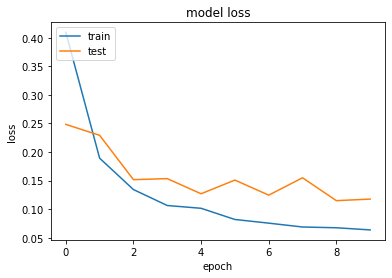

In [20]:
plt.plot(modelbase.history['loss'])
plt.plot(modelbase.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

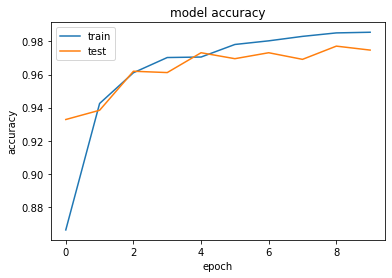

In [21]:
plt.plot(modelbase.history['accuracy'])
plt.plot(modelbase.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
score = model.evaluate(test_x, test_y)
y_pred=model.predict(test_x)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

79/79 [==============================] - 1s 7ms/step
Test Loss: 0.11751478165388107
Test accuracy: 0.9747999906539917


Normalized confusion matrix


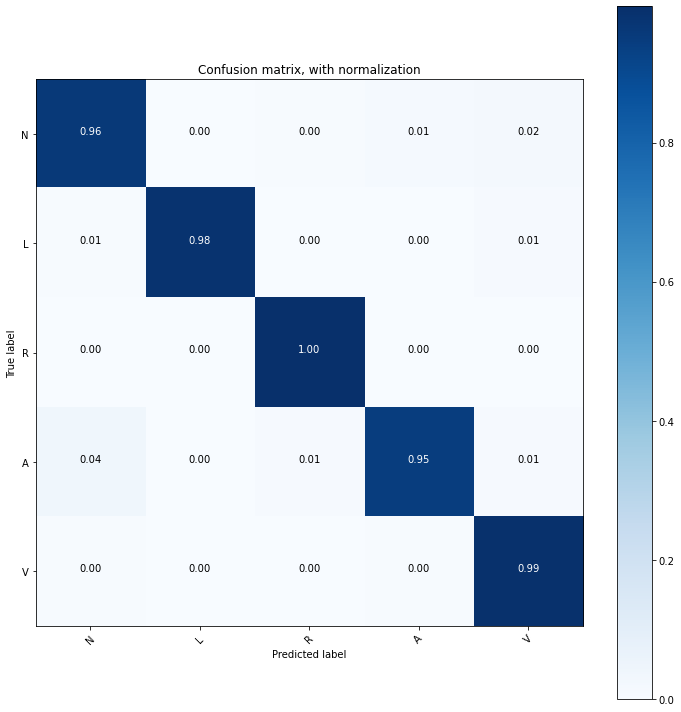

In [23]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'L', 'R', 'A', 'V'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [24]:

from sklearn.model_selection import StratifiedKFold
import numpy as np
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
for i in range(0,5):
	randomnum=np.random.randint(1,6456476)
	train, test = train_test_split(X_train_df, test_size=0.20,random_state=randomnum)

	

	target_train=train[train.shape[1]-1]
	target_test=test[test.shape[1]-1]
	train_y=to_categorical(target_train)
	test_y=to_categorical(target_test)

	train_x = train.iloc[:,:train.shape[1]-1].values
	test_x = test.iloc[:,:test.shape[1]-1].values
	train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
	test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
	print(np.shape(train_x), np.shape(test_x))
	model = Sequential()
	model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))
	model.add(AvgPool1D(pool_size=3, strides=2))
	model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
	model.add(AvgPool1D(pool_size=3, strides=2))
	model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
	model.add(AvgPool1D(pool_size=3, strides=2))
	model.add(Flatten())
	model.add(Dropout(0.5))
	model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
	model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
	model.add(Softmax())
# model.summary()
	model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])	# Fit the model
	model.fit(train_x, train_y, epochs=10, batch_size=36, verbose=1)
	scores = model.evaluate(test_x, test_y, verbose=1)
	print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
	cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

(10000, 360, 1) (2500, 360, 1)
Epoch 1/10
278/278 [==============================] - 8s 26ms/step - loss: 0.4127 - accuracy: 0.8627
Epoch 2/10
278/278 [==============================] - 7s 24ms/step - loss: 0.1726 - accuracy: 0.9476
Epoch 3/10
278/278 [==============================] - 7s 25ms/step - loss: 0.1272 - accuracy: 0.9631
Epoch 4/10
278/278 [==============================] - 7s 24ms/step - loss: 0.1107 - accuracy: 0.9707
Epoch 5/10
278/278 [==============================] - 7s 25ms/step - loss: 0.0994 - accuracy: 0.9721
Epoch 6/10
278/278 [==============================] - 7s 25ms/step - loss: 0.0864 - accuracy: 0.9768
Epoch 7/10
278/278 [==============================] - 7s 24ms/step - loss: 0.0799 - accuracy: 0.9799
Epoch 8/10
278/278 [==============================] - 7s 24ms/step - loss: 0.0726 - accuracy: 0.9816
Epoch 9/10
278/278 [==============================] - 7s 24ms/step - loss: 0.0709 - accuracy: 0.9817
Epoch 10/10
79/79 [==============================] - 1s 7ms/